# Summary

-----

# Imports

In [1]:
%run imports.ipynb

2016-06-29 18:04:32.968037


In [2]:
print2 = ascommon.df_tools.print2

In [3]:
NOTEBOOK_NAME = 'core_to_calculate'
SUFFIX = '_2'

# Load data

In [4]:
db = datapkg.MySQL(
    os.environ['DATAPKG_CONNECTION_STR'], 
    NOTEBOOK_NAME, 
    None, 
    echo=False)

In [7]:
DATA_DF = pd.read_pickle(op.join('core_load_data', 'DATA_DF.pkl'))

## Validate

In [8]:
df = DATA_DF[DATA_DF['dataset'] == 'taipale']
display(df.head())
print(df.shape[0])

,alignment_coverage,alignment_def,alignment_filename,alignment_identity,alignment_score,alignment_subdefs,backbone_clash_change,backbone_clash_wt,backbone_hbond_change,backbone_hbond_wt,cath_id,chain,chain_modeller,cis_bond_change,cis_bond_wt,dataset,db,ddg,ddg_exp,del_class_exp,del_score_exp,dg_change,dg_wt,disulfide_change,disulfide_wt,domain_def,domain_end,domain_start,electrostatic_kon_change,electrostatic_kon_wt,electrostatics_change,electrostatics_wt,energy_ionisation_change,energy_ionisation_wt,entropy_complex_change,entropy_complex_wt,entropy_mainchain_change,entropy_mainchain_wt,entropy_sidechain_change,entropy_sidechain_wt,gene_name,helix_dipole_change,helix_dipole_wt,m_date_modified,matrix_score,max_seq_identity,mloop_entropy_change,mloop_entropy_wt,model_domain_def,model_errors,model_filename,model_filename_mut,model_filename_wt,mut_date_modified,mutation_errors,mutation_modeller,norm_dope,number_of_residues,organism_name,partial_covalent_bonds_change,partial_covalent_bonds_wt,path_to_data,pcv_hbond_change,pcv_hbond_self_change,pcv_hbond_self_wt,pcv_hbond_wt,pcv_salt_equal_change,pcv_salt_equal_self_change,pcv_salt_equal_self_wt,pcv_salt_equal_wt,pcv_salt_opposite_change,pcv_salt_opposite_self_change,pcv_salt_opposite_self_wt,pcv_salt_opposite_wt,pcv_vdw_change,pcv_vdw_self_change,pcv_vdw_self_wt,pcv_vdw_wt,pdbfam_idx,pdbfam_name,pfam_clan,pfam_names,protein_existence,protein_name,provean_score,sasa_score,secondary_structure_change,secondary_structure_wt,sequence_version,sidechain_hbond_change,sidechain_hbond_wt,sloop_entropy_change,sloop_entropy_wt,solvation_hydrophobic_change,solvation_hydrophobic_wt,solvation_polar_change,solvation_polar_wt,solvent_accessibility_change,solvent_accessibility_wt,t_date_modified,template_errors,torsional_clash_change,torsional_clash_wt,uniprot_domain_id,uniprot_domain_id_old,uniprot_id,uniprot_mutation,uniprot_name,uniprot_sequence,van_der_waals_change,van_der_waals_clashes_change,van_der_waals_clashes_wt,van_der_waals_wt,water_bridge_change,water_bridge_wt
52053,100.0,20:279,A4Z6T7_2pfrA.aln,99.65,0.996675,20:279,0.423,177.513,0.762,-194.852,2pfrA00,A,A,0.0,0.0,taipale,tr,0.400170,0.387622,NaN,NaN,6.0769,38.5534,0.0,0.0,1:290,290,1,0.0,0.0,0.14080,-10.52370,-0.204400,1.53934,0.0,0.0,2.417,441.105,-0.235,199.524,NAT2,0.00000,-9.19542,2015-03-14 07:05:21,-3.0,NaN,0.0,0.0,1:290,None,A4Z6T7_2pfrA.pdb,A4Z6T7_G286E/MUT_RepairPDB_A4Z6T7_2pfrA_1.pdb,A4Z6T7_G286E/WT_RepairPDB_A4Z6T7_2pfrA_1.pdb,2015-07-02 03:29:29,None,G286E,-1.51582,290.0,Homo sapiens,0.0,0.0,human/A4Z/6T/A4Z6T7/Acetyltransf_2.20-279/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Acetyltransf_2,Acetyltransf_2,Acetyltransf_2|1,3.0,Arylamine N-acetyltransferase 2,0.176,"90.02,34.43,16.58,70.43,27.24,0.00,5.78,74.64,...",0,7.0,1.0,0.7618,-85.2952,0.0,0.0,-1.210,-492.498,1.334,479.627,20.79520,28.58110,2015-09-01 05:12:36,None,1.0366,34.1418,84840104,NaN,A4Z6T7,G286E,A4Z6T7_HUMAN,MDIEAYFERIGYKNSRNKLDLETLTDILEHQIRAVPFENLNMHCGQ...,-0.939,2.2125,44.0919,-369.111,0.0,0.0
52054,100.0,20:279,A4Z6T7_2pfrA.aln,99.65,0.996675,20:279,-0.289,177.478,2.266,-194.561,2pfrA00,A,A,0.0,0.0,taipale,tr,1.465550,2.421890,NaN,NaN,5.5316,37.8203,0.0,0.0,1:290,290,1,0.0,0.0,0.00090,-10.52320,0.000000,1.53934,0.0,0.0,0.170,441.104,-1.520,197.813,NAT2,0.00000,-9.19471,2015-03-14 07:05:21,-2.0,NaN,0.0,0.0,1:290,None,A4Z6T7_2pfrA.pdb,A4Z6T7_Q145P/MUT_RepairPDB_A4Z6T7_2pfrA_1.pdb,A4Z6T7_Q145P/WT_RepairPDB_A4Z6T7_2pfrA_1.pdb,2015-07-02 03:21:34,None,Q145P,-1.51582,290.0,Homo sapiens,0.0,0.0,human/A4Z/6T/A4Z6T7/Acetyltransf_2.20-279/,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,1,Acetyltransf_2,Acetyltransf_2,Acetyltransf_2|1,3.0,Arylamine N-acetyltransferase 2,-5.800,"90.02,34.43,16.58,70.43,27.24,0.00,5.78,74.64,...",1,2.0,1.0,1.3876,-83.6919,0.0,0.0,0.471,-492.495,-2.078,479.233,3.18620,10.46140,2015-09-01 05:12:36,None,-0.2435,33.6173,84840104,NaN,A4Z6T7,Q145P,A4Z6T7_HUMAN,MDIEAYFERIGYKNSRNKLDLETLTDILEHQIRAVPFEN

1920


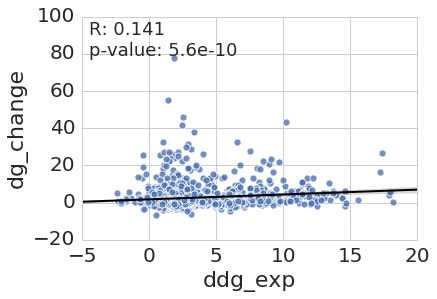

In [27]:
# Some validation to make sure that we 
fg, ax = plt.subplots()
ascommon.plotting_tools.make_plot_with_corr(
    x='ddg_exp', 
    y='dg_change',
    data=DATA_DF[DATA_DF['dataset'] == 'taipale'][['ddg_exp', 'dg_change']], 
    ax=ax,
    corr_type='pearson'
)

# ...

In [10]:
# Mutaton in domain
DATA_DF['mutation_in_domain'] = (
    DATA_DF[['uniprot_mutation', 'domain_def']]
    .apply(lambda x: ascommon.sequence_tools.mutation_in_domain(*x), axis=1)
)

In [11]:
# Mutation in model domain
DATA_DF['mutation_in_model_domain'] = (
    DATA_DF[['uniprot_mutation', 'model_domain_def']]
    .apply(lambda x: ascommon.sequence_tools.mutation_in_domain(*x), axis=1)
)

In [12]:
# Mutation to calculate
DATA_DF['mutation_to_calculate'] = (
    (DATA_DF['ddg'].isnull()) & 
    ((DATA_DF['mutation_in_model_domain'] == True) | 
     (DATA_DF['mutation_in_model_domain'].isnull() & (DATA_DF['mutation_in_domain'] == True)))
)

In [13]:
_num_to_calculate = sum((DATA_DF['mutation_to_calculate'] == True).astype(bool))
_num_calculated = sum((DATA_DF['mutation_to_calculate'] == False).astype(bool))
assert _num_to_calculate + _num_calculated == DATA_DF.shape[0]

print2('To calculate:', _num_to_calculate)
print2('Calculated or hopeless:', _num_calculated)
print2('Have ddG:', sum(DATA_DF['ddg'].notnull()))

To calculate:                                               24922
Calculated or hopeless:                                     473786
Have ddG:                                                   473786


In [28]:
DATA_DF[DATA_DF['ddg'].isnull()][[
    'uniprot_mutation', 
    'domain_def', 'mutation_in_domain',
    'model_domain_def', 'mutation_in_model_domain',
    'mutation_to_calculate', 'ddg'
]].head()

,uniprot_mutation,domain_def,mutation_in_domain,model_domain_def,mutation_in_model_domain,mutation_to_calculate,ddg
1003,M87A,36:100,True,36:93,True,True,NaN
1006,R88A,36:100,True,36:93,True,True,NaN
1009,T89A,36:100,True,36:93,True,True,NaN
1012,G91A,36:100,True,36:93,True,True,NaN
1015,G92A,36:100,True,36:93,True,True,NaN


## **elaspic_to_calculate**

In [29]:
elaspic_to_calculate = (
    DATA_DF
    [(DATA_DF['mutation_to_calculate'] == True)]
    .drop_duplicates(subset=['uniprot_id', 'uniprot_mutation'])
    .groupby('uniprot_id')
    .agg({'uniprot_mutation': lambda x: ':'.join(x)})
    .reset_index()
)

In [30]:
print(elaspic_to_calculate.shape)

(382, 2)


In [31]:
elaspic_to_calculate.head()

,uniprot_id,uniprot_mutation
0,A4D0S4,N268K:C865R:R1163W:E1168K:R1160S:C1158Y:C1147W...
1,A4GXA9,R352H:R350H:Q71R:E86A:A99V:P130T:P168L:R197Q:E...
2,A6NHN0,K324R:R157C:P175T:P107L:V108L:G113E:G122C:G128...
3,A6NMZ7,L1418P:Q1533K:A1429V:A1614S:G1395C:M1397V:G139...
4,A7E2Y1,E781K


## Create grid

In [32]:
config_file = ('/home/kimlab1/strokach/working/elaspic/config/config_file_mysql.ini')
print(config_file)

system_command_template = (
    "elaspic run -c {config_file} -u {{uniprot_id}} -m {{mutations}}"
    .format(config_file=config_file)
)

elaspic_to_calculate['system_command'] = (
    elaspic_to_calculate
    [['uniprot_id', 'uniprot_mutation']]
    .apply(lambda x: system_command_template.format(uniprot_id=x[0], mutations=x[1]), axis=1)
)

/home/kimlab1/strokach/working/elaspic/config/config_file_mysql.ini


In [33]:
elaspic_to_calculate.head()

,uniprot_id,uniprot_mutation,system_command
0,A4D0S4,N268K:C865R:R1163W:E1168K:R1160S:C1158Y:C1147W...,elaspic run -c /home/kimlab1/strokach/working/...
1,A4GXA9,R352H:R350H:Q71R:E86A:A99V:P130T:P168L:R197Q:E...,elaspic run -c /home/kimlab1/strokach/working/...
2,A6NHN0,K324R:R157C:P175T:P107L:V108L:G113E:G122C:G128...,elaspic run -c /home/kimlab1/strokach/working/...
3,A6NMZ7,L1418P:Q1533K:A1429V:A1614S:G1395C:M1397V:G139...,elaspic run -c /home/kimlab1/strokach/working/...
4,A7E2Y1,E781K,elaspic run -c /home/kimlab1/strokach/working/...


## Test

In [34]:
test_system_command = elaspic_to_calculate['system_command'][0]

In [35]:
!echo {test_system_command}

elaspic run -c /home/kimlab1/strokach/working/elaspic/config/config_file_mysql.ini -u A4D0S4 -m N268K:C865R:R1163W:E1168K:R1160S:C1158Y:C1147W:G1145V:P1127S:S824L:D808N:G805R:R797C:G785E:G778E:C769Y:F544L:Q325H:D323E:E307K:D283H:R281Q:R281W:R275H:E273V:E273K:G263E:R262Q:R262W:Y257F:A255D:Y254H:G242R:T235I:K232N:N225D:E210K:I209S:P205S:D189Y:D189N:S188L:S185Y:D180E:V178A:S146F:R137Q:I130T:S107Y:P98T:H87N:D79N:C69Y:K68R:G65W:E64K:R53T:G50E:A45V:L43I:T41M:T41K:G38S:L35I:G26V


In [36]:
!{test_system_command} > $NOTEBOOK_NAME/stdout.log 2>&1

In [37]:
!cat $NOTEBOOK_NAME/stdout.log | tail

    instance.run()
  File "/home/kimlab1/strokach/working/elaspic/elaspic/database_pipeline.py", line 724, in run
    results = self.model.mutate(mut_data.mutation_idx, mut_data.mutation_domain)
  File "/home/kimlab1/strokach/working/elaspic/elaspic/elaspic_model.py", line 518, in mutate
    chain_id, mutation_modeller, partner_chain_id)
  File "/home/kimlab1/strokach/working/elaspic/elaspic/structure_analysis.py", line 85, in __call__
    secondary_structure_df = self.get_secondary_structure()
  File "/home/kimlab1/strokach/working/elaspic/elaspic/structure_analysis.py", line 413, in get_secondary_structure
    with open(stride_results_file) as fh:
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/strokach/elaspic/aanjuhqy/model/mutations/A4D0S4.544:544--F1L/WT_REPAIRPDB_A4D0S4_4AQSA_1A_stride_results.txt'


In [24]:
raise Exception

Exception: 

## SGE

In [ ]:
PATH = (
    '/home/kimlab1/strokach/anaconda/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin'
)

js_beagle = ascommon.cluster_tools.JobSubmitter(
    'elaspic_to_calculate{}'.format(SUFFIX), 'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='8:00:00', mem='2G',
    env={'PATH': PATH}
)

In [ ]:
elaspic_to_calculate.reset_index()[['index', 'system_command']].values.tolist()[:2]

In [ ]:
with js_beagle.connect():
    js_beagle.submit(
        elaspic_to_calculate.reset_index()[['index', 'system_command']].values.tolist())

## PBS

In [ ]:
PATH = (
    '/home/kimlab1/strokach/anaconda/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin'
)

js_bc = ascommon.cluster_tools.JobSubmitter(
    'elaspic_to_calculate{}'.format(SUFFIX), 'pbs://:@192.168.233.150', op.abspath(NOTEBOOK_NAME),
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='8:00:00', mem='2G',
    env={'PATH': PATH},
    concurrent_job_limit=800
)

In [ ]:
list(reversed(elaspic_to_calculate.reset_index()[['index', 'system_command']].values.tolist()[:2]))

In [ ]:
with js_bc.connect():
    js_bc.submit(
        reversed(elaspic_to_calculate.reset_index()[['index', 'system_command']].values.tolist()))

# Save